In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler ,RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import SGD  # Example optimizer

In [2]:
df = pd.read_csv('./dataset/hungarian.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,4,140,260,0,1,112,1,3,2,?,?,2
1,44,1,4,130,209,0,1,127,0,0,?,?,?,0
2,60,1,4,132,218,0,1,140,1,1.5,3,?,?,2
3,55,1,4,142,228,0,1,149,1,2.5,1,?,?,1
4,66,1,3,110,213,1,2,99,1,1.3,2,?,?,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       200 non-null    int64 
 1   sex       200 non-null    int64 
 2   cp        200 non-null    int64 
 3   trestbps  200 non-null    object
 4   chol      200 non-null    object
 5   fbs       200 non-null    object
 6   restecg   200 non-null    int64 
 7   thalach   200 non-null    object
 8   exang     200 non-null    object
 9   oldpeak   200 non-null    object
 10  slope     200 non-null    object
 11  ca        200 non-null    object
 12  thal      200 non-null    object
 13  num       200 non-null    int64 
dtypes: int64(5), object(9)
memory usage: 22.0+ KB


In [4]:
# creating a copy of original dataset
heart = df

In [5]:
columns_with_missing_values = ['trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

for column in columns_with_missing_values:
    heart[column] = heart[column].replace('?', np.nan)


In [6]:
#check for missing value in entire dataframe
heart.isnull().sum()

age           0
sex           0
cp            0
trestbps     56
chol          7
fbs           7
restecg       0
thalach      53
exang        53
oldpeak      56
slope       102
ca          198
thal        166
num           0
dtype: int64

#### Dimension reduction

In [7]:
# more than 80% data missing for thal column and almost all missing for ca column therefore dropping them
heart.drop(columns=['ca', 'thal'], inplace=True)

#### Correcting the data types of attributes

In [8]:
# Convert specific columns to numeric
numeric_columns = ['trestbps', 'chol', 'thalach', 'oldpeak']

for column in numeric_columns:
    heart[column] = pd.to_numeric(heart[column], errors='coerce')

In [9]:
# Convert specific columns to categorical
categorical_columns = ['sex', 'num','cp','restecg']

for column in categorical_columns:
    heart[column] = heart[column].astype('object')


In [10]:
heart.dtypes

age           int64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
num          object
dtype: object

#### Handle Missing Values:

In [11]:
# First, create a function to fill missing values with the mode based on another column
def fill_with_mode(df, column, groupby_column):
    # Calculate the mode for each group and handle cases with no mode
    mode_by_group = df.groupby(groupby_column)[column].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df[column] = df[column].fillna(df[groupby_column].map(mode_by_group))

In [12]:
def fill_with_median(df, column, groupby_columns):
    for group in df.groupby(groupby_columns):
        group_filter = (df[groupby_columns] == group[0]).all(axis=1)
        if group_filter.any():
            df.loc[group_filter, column] = df.loc[group_filter, column].fillna(group[1][column].median())


For categorical columns (slope, ca, thal), we can fill missing values with the mode or a specific category depending on the domain knowledge.

In [13]:
# Fill missing values in 'slope', 'ca', 'thal', 'fbs', and 'exang' with mode based on 'num' (the target)
fill_with_mode(heart, 'slope', 'num')

For binary columns (fbs, exang), we can fill missing values with the mode (most frequent value) of the respective column.

In [14]:
fill_with_mode(heart, 'fbs', 'num')
fill_with_mode(heart, 'exang', 'num')

For numeric columns (trestbps, chol, thalach, oldpeak), we can fill missing values with the mean or median of the respective column. This helps to preserve the distribution of the data.

In [15]:
# Replace 'column_name' with the name of the column we want to visualize
def KDEplot(column_name,df=heart):
    sns.kdeplot(df[column_name], fill=True)
    plt.title(f'Distribution of {column_name}')
    plt.show()

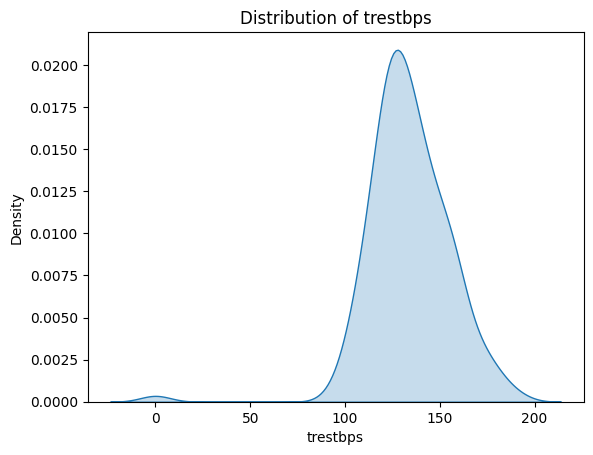

In [16]:
KDEplot('trestbps')

In [17]:
fill_with_median(heart, 'trestbps', ['cp','sex'])

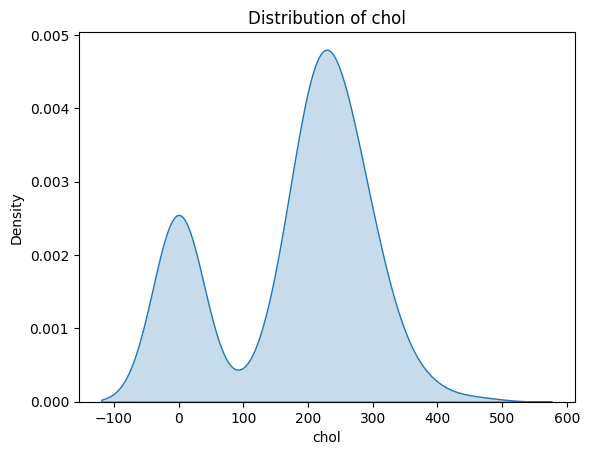

In [18]:
KDEplot('chol')

In [19]:
fill_with_median(heart, 'chol', ['sex', 'cp'])

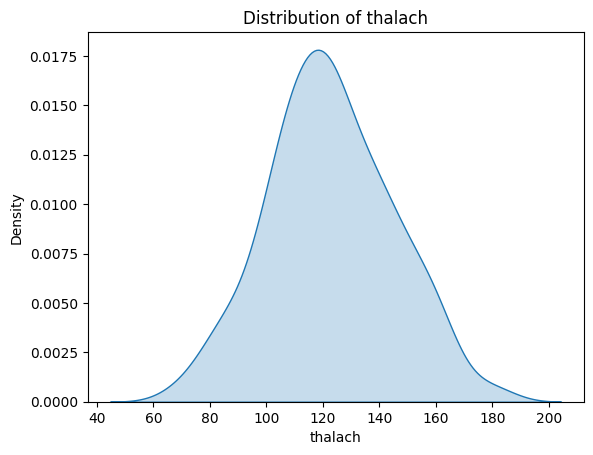

In [20]:
KDEplot('thalach')

In [21]:
fill_with_median(heart, 'thalach', ['cp','sex'])

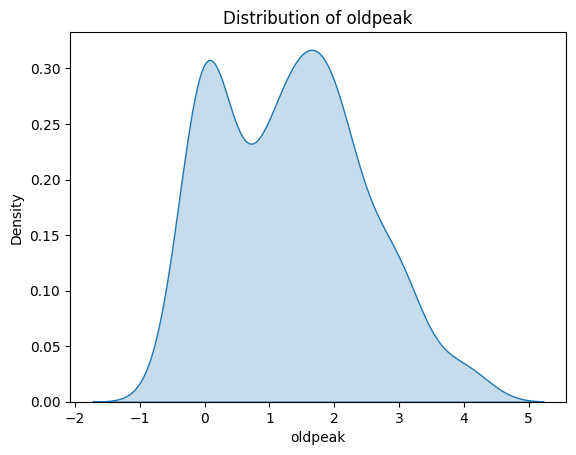

In [22]:
KDEplot('oldpeak')

In [23]:
fill_with_median(heart, 'oldpeak', ['cp','sex'])

In [24]:
#check for missing value in entire dataframe
heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64

In [25]:
heart.describe()

,age,trestbps,chol,thalach,oldpeak
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,59.350000,132.710000,179.967500,122.855000,1.315500
std,7.811697,18.478179,112.201834,19.155643,0.974929
min,35.000000,0.000000,0.000000,69.000000,-0.500000
25%,55.000000,125.000000,129.250000,112.000000,0.650000
50%,60.000000,132.000000,216.500000,120.000000,1.500000
75%,64.000000,140.000000,254.500000,135.000000,2.000000
max,77.000000,190.000000,458.000000,180.000000,4.000000


#### Data Preprocessing

In [26]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       200 non-null    int64  
 1   sex       200 non-null    object 
 2   cp        200 non-null    object 
 3   trestbps  200 non-null    float64
 4   chol      200 non-null    float64
 5   fbs       200 non-null    object 
 6   restecg   200 non-null    object 
 7   thalach   200 non-null    float64
 8   exang     200 non-null    object 
 9   oldpeak   200 non-null    float64
 10  slope     200 non-null    object 
 11  num       200 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 18.9+ KB


**Outlier detection**

In [27]:
# Define a function to detect and output outliers for a given column
def detect_outliers(column_name,df):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers

In [28]:
# Define the columns for which we want to detect outliers
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Iterate through the columns and check for outliers
for column in columns_to_visualize:
    outliers = detect_outliers(column,heart)
    print(f'Outliers in column "{column}":')
    print(outliers)

Outliers in column "age":
     age sex cp  trestbps   chol fbs restecg  thalach exang  oldpeak slope num
41    40   1  4     125.0    0.0   1       0    165.0     0      0.0     2   1
43    41   1  4     104.0    0.0   0       1    111.0     0      0.0     2   0
91    40   1  3     106.0  240.0   0       0     80.0     1      0.0     2   0
96    35   1  3     125.0  161.0   0       1    120.0     0      1.0     2   0
150   41   1  4     150.0  171.0   0       0    128.0     1      1.5     2   0
152   38   1  4     110.0  289.0   0       0    105.0     1      1.5     3   1
171   37   1  3     118.0  240.0   0       2    165.0     0      1.0     2   0
Outliers in column "trestbps":
     age sex cp  trestbps   chol fbs restecg  thalach exang  oldpeak slope num
7     60   1  3     180.0    0.0   0       1    140.0     1      1.5     2   0
16    63   1  4     170.0  177.0   0       0     84.0     1      2.5     3   4
33    55   1  3       0.0    0.0   0       0    155.0     0      1.5     2

- 7 outlierss in age column
- 13 outliers in trestbp
- 1 outliers  in chol
- 4 outliers in thal
- 0 outliers in oldpeak

**Normalization**

Min-Max Normalization:
This scales the data to fall within a specified range, usually [0, 1].

In [29]:
minmax_normalized_df=heart.copy()
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()

# Select the columns we want to normalize
columns_to_normalize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply Min-Max normalization to selected columns
minmax_normalized_df[columns_to_normalize] = minmax_scaler.fit_transform(minmax_normalized_df[columns_to_normalize])


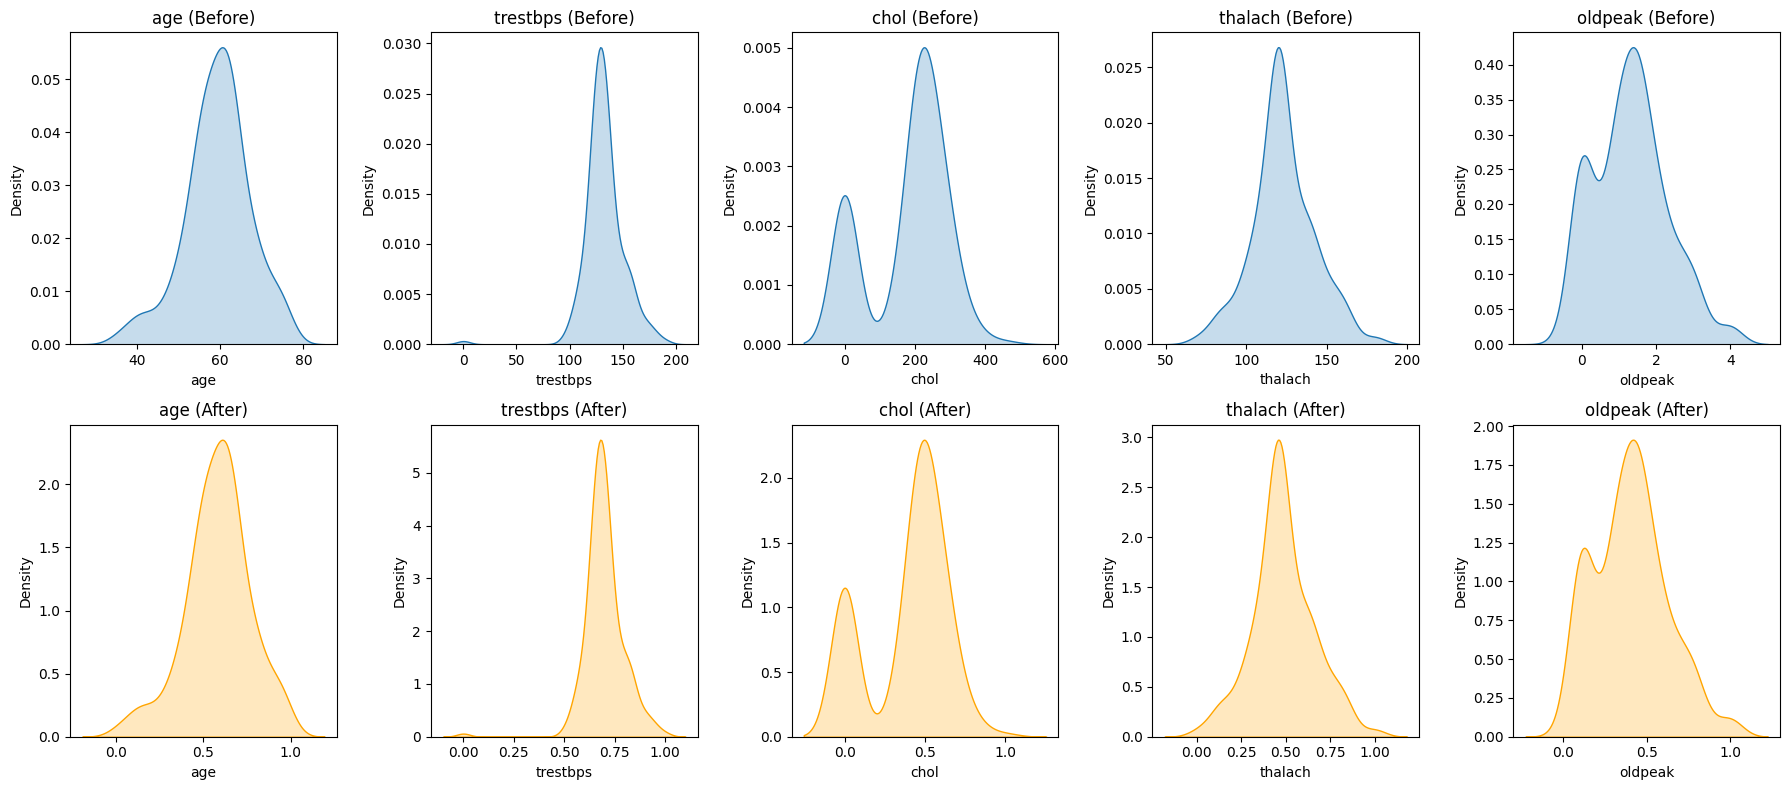

In [30]:
# Define the columns to visualize
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create subplots to compare distributions before and after robust standardization
fig, axes = plt.subplots(nrows=2, ncols=len(columns_to_visualize), figsize=(18, 8))

for i, column in enumerate(columns_to_visualize):
    # Plot the distribution before standardization
    sns.kdeplot(heart[column], ax=axes[0, i], label=f'{column} (Before)', fill=True)
    axes[0, i].set_title(f'{column} (Before)')
    
    # Plot the distribution after standardization
    sns.kdeplot(minmax_normalized_df[column], ax=axes[1, i], color='orange',label=f'{column} (After)', fill=True)
    axes[1, i].set_title(f'{column} (After)')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [31]:
# Define the columns for which we want to detect outliers
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Iterate through the columns and check for outliers
for column in columns_to_visualize:
    outliers = detect_outliers(column,minmax_normalized_df)
    print(f'Outliers in column "{column}":')
    print(outliers)

Outliers in column "age":
          age sex cp  trestbps      chol fbs restecg   thalach exang  \
41   0.119048   1  4  0.657895  0.000000   1       0  0.864865     0   
43   0.142857   1  4  0.547368  0.000000   0       1  0.378378     0   
91   0.119048   1  3  0.557895  0.524017   0       0  0.099099     1   
96   0.000000   1  3  0.657895  0.351528   0       1  0.459459     0   
150  0.142857   1  4  0.789474  0.373362   0       0  0.531532     1   
152  0.071429   1  4  0.578947  0.631004   0       0  0.324324     1   
171  0.047619   1  3  0.621053  0.524017   0       2  0.864865     0   

      oldpeak slope num  
41   0.111111     2   1  
43   0.111111     2   0  
91   0.111111     2   0  
96   0.333333     2   0  
150  0.444444     2   0  
152  0.444444     3   1  
171  0.333333     2   0  
Outliers in column "trestbps":
          age sex cp  trestbps      chol fbs restecg   thalach exang  \
7    0.595238   1  3  0.947368  0.000000   0       1  0.639640     1   
16   0.666667 

Z-score Normalization (Standardization):
This scales the data to have a mean of 0 and a standard deviation of 1.

In [32]:
zscore_normalized_df=heart.copy()
# Create a StandardScaler object
zscore_scaler = StandardScaler()

# Select the columns we want to standardize
columns_to_standardize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply Z-score normalization to selected columns
zscore_normalized_df[columns_to_standardize] = zscore_scaler.fit_transform(zscore_normalized_df[columns_to_standardize])


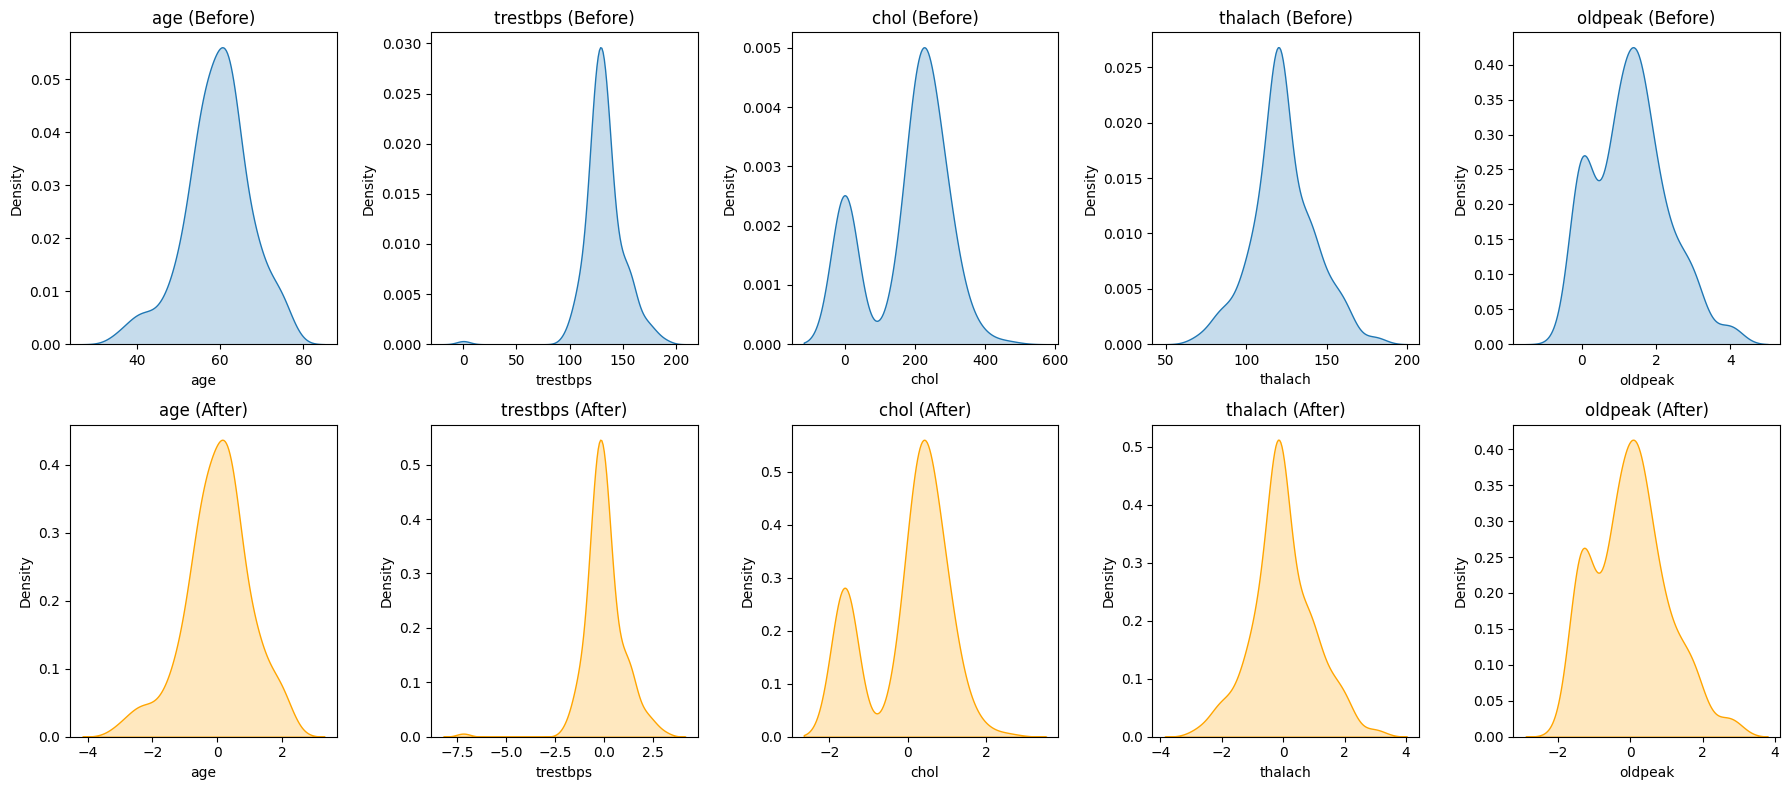

In [33]:
# Define the columns to visualize
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create subplots to compare distributions before and after robust standardization
fig, axes = plt.subplots(nrows=2, ncols=len(columns_to_visualize), figsize=(18, 8))

for i, column in enumerate(columns_to_visualize):
    # Plot the distribution before standardization
    sns.kdeplot(heart[column], ax=axes[0, i], label=f'{column} (Before)', fill=True)
    axes[0, i].set_title(f'{column} (Before)')
    
    # Plot the distribution after standardization
    sns.kdeplot(zscore_normalized_df[column], ax=axes[1, i], color='orange',label=f'{column} (After)', fill=True)
    axes[1, i].set_title(f'{column} (After)')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [34]:
# Define the columns for which we want to detect outliers
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Iterate through the columns and check for outliers
for column in columns_to_visualize:
    outliers = detect_outliers(column,zscore_normalized_df)
    print(f'Outliers in column "{column}":')
    print(outliers)

Outliers in column "age":
          age sex cp  trestbps      chol fbs restecg   thalach exang  \
41  -2.483270   1  4 -0.418296 -1.607987   1       0  2.205656     0   
43  -2.354936   1  4 -1.557623 -1.607987   0       1 -0.620431     0   
91  -2.483270   1  3 -1.449116  0.536383   0       0 -2.242814     1   
96  -3.124942   1  3 -0.418296 -0.169472   0       1 -0.149416     0   
150 -2.354936   1  4  0.938046 -0.080123   0       0  0.269263     1   
152 -2.739939   1  4 -1.232101  0.974192   0       0 -0.934440     1   
171 -2.868274   1  3 -0.798072  0.536383   0       2  2.205656     0   

      oldpeak slope num  
41  -1.352715     2   1  
43  -1.352715     2   0  
91  -1.352715     2   0  
96  -0.324425     2   0  
150  0.189719     2   0  
152  0.189719     3   1  
171 -0.324425     2   0  
Outliers in column "trestbps":
          age sex cp  trestbps      chol fbs restecg   thalach exang  \
7    0.083417   1  3  2.565657 -1.607987   0       1  0.897283     1   
16   0.468421 

Robust Standardization:
Robust Standardization is even more robust to outliers. It scales the data based on the median and the interquartile range (IQR).

In [35]:
robust_normalized_df = heart.copy()
# Create a RobustScaler object
robust_scaler = RobustScaler()

# Select the columns we want to robustly standardize
columns_to_robust_standardize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply Robust Standardization to selected columns
robust_normalized_df[columns_to_robust_standardize] = robust_scaler.fit_transform(robust_normalized_df[columns_to_robust_standardize])

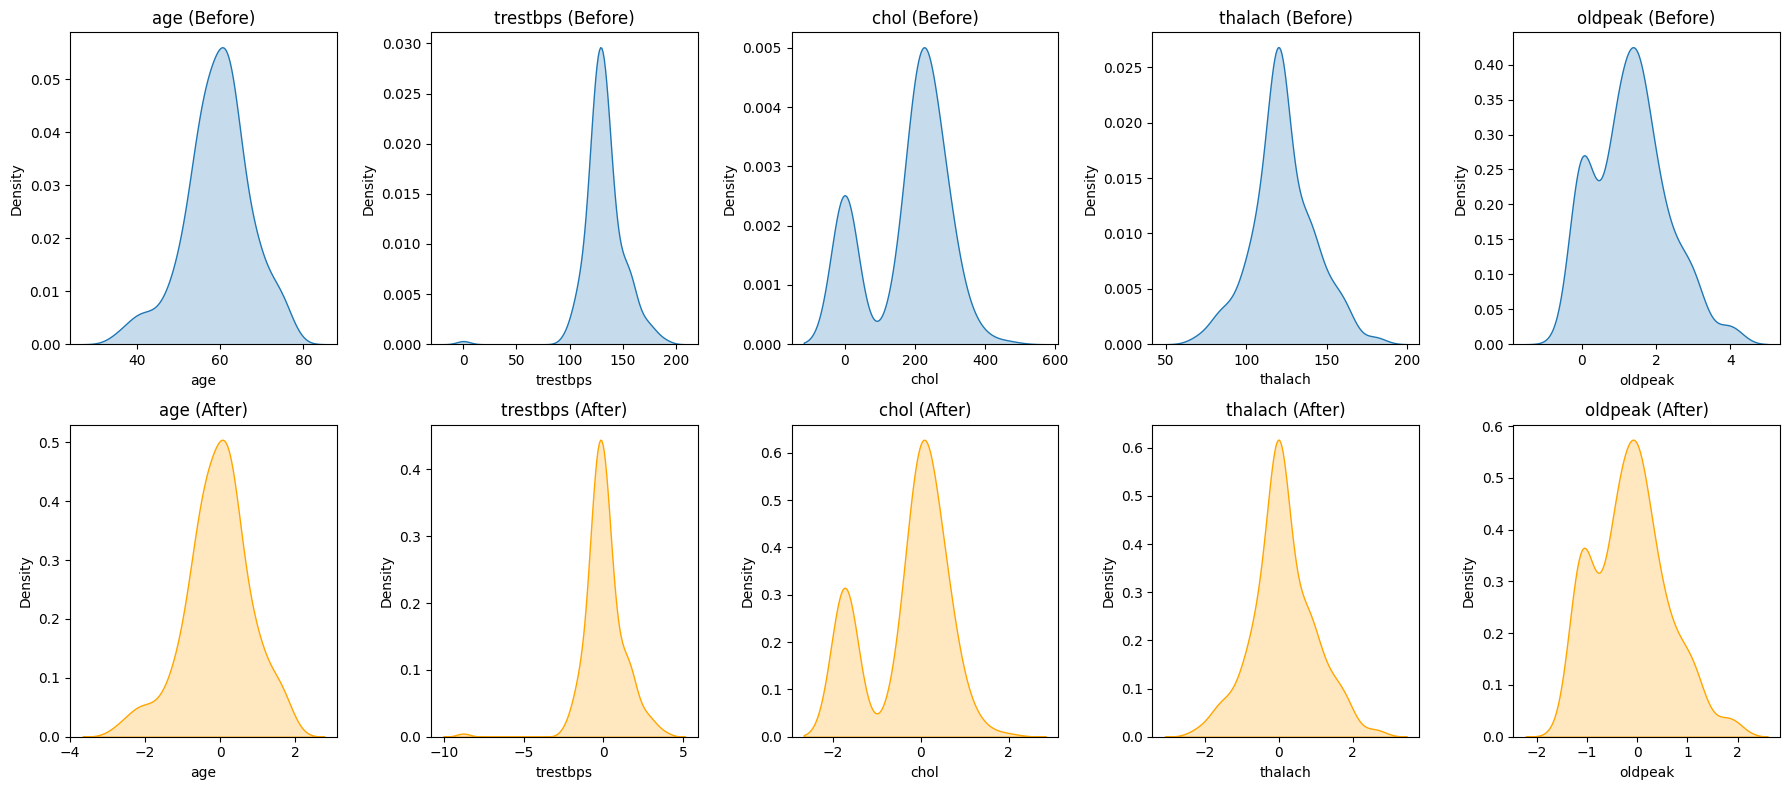

In [36]:
# Define the columns to visualize
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create subplots to compare distributions before and after robust standardization
fig, axes = plt.subplots(nrows=2, ncols=len(columns_to_visualize), figsize=(18, 8))

for i, column in enumerate(columns_to_visualize):
    # Plot the distribution before standardization
    sns.kdeplot(heart[column], ax=axes[0, i], label=f'{column} (Before)', fill=True)
    axes[0, i].set_title(f'{column} (Before)')
    
    # Plot the distribution after standardization
    sns.kdeplot(robust_normalized_df[column], ax=axes[1, i], color='orange',label=f'{column} (After)', fill=True)
    axes[1, i].set_title(f'{column} (After)')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [37]:
# Define the columns for which we want to detect outliers
columns_to_visualize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Iterate through the columns and check for outliers
for column in columns_to_visualize:
    outliers = detect_outliers(column,robust_normalized_df)
    print(f'Outliers in column "{column}":')
    print(outliers)

Outliers in column "age":
          age sex cp  trestbps      chol fbs restecg   thalach exang  \
41  -2.222222   1  4 -0.466667 -1.728543   1       0  1.956522     0   
43  -2.111111   1  4 -1.866667 -1.728543   0       1 -0.391304     0   
91  -2.222222   1  3 -1.733333  0.187625   0       0 -1.739130     1   
96  -2.777778   1  3 -0.466667 -0.443114   0       1  0.000000     0   
150 -2.111111   1  4  1.200000 -0.363273   0       0  0.347826     1   
152 -2.444444   1  4 -1.466667  0.578842   0       0 -0.652174     1   
171 -2.555556   1  3 -0.933333  0.187625   0       2  1.956522     0   

      oldpeak slope num  
41  -1.111111     2   1  
43  -1.111111     2   0  
91  -1.111111     2   0  
96  -0.370370     2   0  
150  0.000000     2   0  
152  0.000000     3   1  
171 -0.370370     2   0  
Outliers in column "trestbps":
          age sex cp  trestbps      chol fbs restecg   thalach exang  \
7    0.000000   1  3  3.200000 -1.728543   0       1  0.869565     1   
16   0.333333 

In [38]:
# Putting feature variable to X
X = heart.drop('num',axis=1)

# Putting response variable to y
y = np.where(heart['num'] > 1, 1, 0)

In [53]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,1,4,140.0,260.0,0,1,112.0,1,3.0,2
1,44,1,4,130.0,209.0,0,1,127.0,0,0.0,2
2,60,1,4,132.0,218.0,0,1,140.0,1,1.5,3
3,55,1,4,142.0,228.0,0,1,149.0,1,2.5,1
4,66,1,3,110.0,213.0,1,2,99.0,1,1.3,2
...,...,...,...,...,...,...,...,...,...,...,...
195,54,0,4,127.0,333.0,1,1,154.0,0,0.0,2
196,62,1,1,136.0,139.0,0,1,135.0,0,2.5,2
197,55,1,4,122.0,223.0,1,1,100.0,0,0.0,2
198,58,1,4,133.0,385.0,1,2,120.0,0,1.5,2


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((160, 11), (40, 11))

First we will fit a normal decision tree without any fine tuning and check the results

In [40]:

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [41]:
print(f'Train score {accuracy_score(y_train_pred,y_train)*100}%')
print(f'Test score {accuracy_score(y_test_pred,y_test)*100}%')

Train score 100.0%
Test score 62.5%


 We have just 62% accuracy on test inputs. Our model is clearly overfitting. We will avoid overfitting through pruning.

**Pre pruning**


There are several ways to pre prun the decision tree .For instance limiting parameters like max_depth , min_samples etc.

An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performace on test data.

In [42]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,5,8],
         'min_samples_leaf': [1,2,4,5]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 3, 5, 8]})

In [43]:
print(gcv.best_params_)

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [44]:
model = gcv.best_estimator_
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9125
Test score 0.675


Though the accuracy on test input increased but still the improvement is very little.

**Post pruning techniques**

We will use Cost complexity pruning,where we will find the best parameter for alpha.We will get the alpha values for this tree and will check the accuracy with the pruned trees.

In [45]:
# The cost-complexity pruning path is a sequence of subtrees of the original decision tree, where each subtree corresponds to a different value of the cost-complexity parameter (ccp_alpha).
path = clf.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas gives minimum leaf value of decision tree and each ccp_aphas will create different - different classifier and choose best out of it
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00416667 0.00666667 0.00752315 0.00777778 0.00833333
 0.00880208 0.00913743 0.00969231 0.01       0.01041667 0.01467014
 0.01563805 0.01615171 0.02506944 0.02604167 0.02834776 0.06305031]


 Smaller values of ccp_alpha lead to more complex trees (less pruning), while larger values of ccp_alpha result in simpler trees (more pruning).

In [46]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

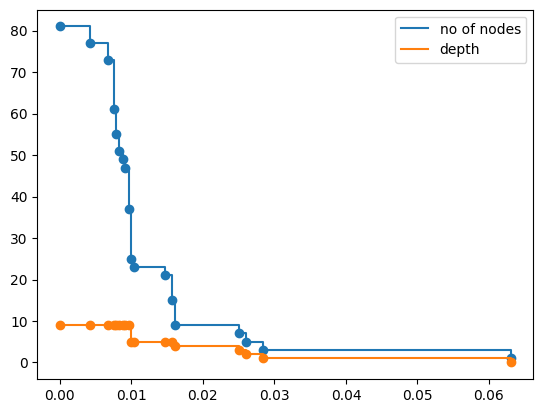

In [47]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

As alpha increases no of nodes and depth decreases

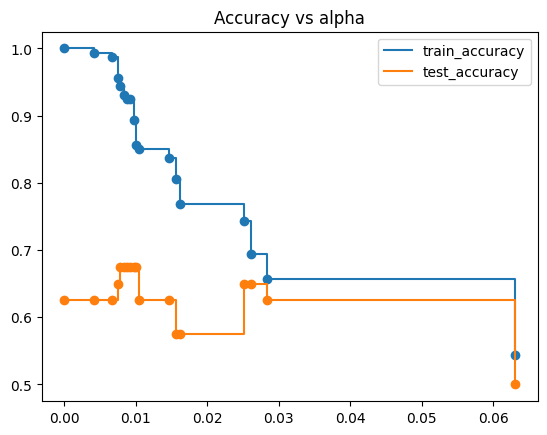

In [48]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

Therefore best training accuracy for alpha around 0.009

In [49]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.009)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.925
Test score 0.675


Let us see what happens if we take an alpha < optimal alpha 

In [50]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.004)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 1.0
Test score 0.625


Let us see what happens if we take an alpha > optimal alpha 

In [51]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.014)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.85
Test score 0.625


Therefore in either case when alpha is not alpha optimal , the accuracy reduces

#### Build a simple neural network and predict

In [60]:
# Preprocessing - scaling the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [65]:

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),#The input layer has as many neurons as there are features
    layers.Dense(64, activation='relu'),#hidden layer with 64 neurons and relu as activation function
    layers.Dense(32, activation='relu'),#hidden layer with 32 neurons and relu as activation function
    layers.Dense(1, activation='sigmoid')#output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

2/2 [==============================] - 0s 4ms/step
Test accuracy: 0.675


Let us examine what happens if we change the activation functions in hidden layers

In [66]:
model2 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),#The input layer has as many neurons as there are features
    layers.Dense(64, activation='sigmoid'),#hidden layer with 64 neurons and relu as activation function
    layers.Dense(32, activation='sigmoid'),#hidden layer with 32 neurons and relu as activation function
    layers.Dense(1, activation='sigmoid')#output layer
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

2/2 [==============================] - 0s 5ms/step
Test accuracy: 0.625


As we can see the accuracy dropped, this may be due to vanishing gradient problem with sigmoid funciton

Let us examine what happends if we increase the hidden layer count

In [67]:
model3 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),#The input layer has as many neurons as there are features
    layers.Dense(64, activation='relu'),#hidden layer with 64 neurons and relu as activation function
    layers.Dense(32, activation='relu'),#hidden layer with 32 neurons and relu as activation function
    layers.Dense(16, activation='relu'),#hidden layer with 16 neurons and relu as activation function
    layers.Dense(1, activation='sigmoid')#output layer
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model3.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred = model3.predict(X_test)
y_pred = (y_pred > 0.5)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

2/2 [==============================] - 0s 3ms/step
Test accuracy: 0.65


Increasing the layer has lead to decrease in accuracy, probably due to overfitting